In [ ]:
# -*- coding: utf-8 -*-
"""
CET313 AI Assignment - Spam Detection System
100% Working Google Colab Version
"""

# @title Step 1: Install and Import Packages (WITH NLTK FIX)
!pip install numpy pandas scikit-learn nltk tensorflow shap matplotlib seaborn --quiet
!python -m nltk.downloader all --quiet  # This fixes all NLTK data issues

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import shap

# Verify NLTK downloads
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    print("✓ All NLTK data downloaded successfully")
except LookupError:
    print("Error: NLTK data missing - run !python -m nltk.downloader all")

# @title Step 2: Download Dataset
!wget -q https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print(f"✓ Dataset loaded ({len(df)} messages)")
print("Sample data:")
display(df.head())

# @title Step 3: Bulletproof Text Cleaning
def clean_text(text):
    try:
        # Convert to string if not already
        text = str(text)
        # Lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]|[\d_]', '', text)
        # Tokenize
        tokens = nltk.word_tokenize(text)
        # Remove stopwords and short tokens
        tokens = [word for word in tokens if word not in stopwords.words('english') and len(word) > 2]
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Warning: Could not process text '{text[:50]}...' - {str(e)}")
        return ""

print("\nCleaning text data...")
df['cleaned_text'] = df['text'].apply(clean_text)

# Remove any empty strings that might have been created
df = df[df['cleaned_text'].str.len() > 0]

print("\n✓ Text cleaning completed")
print("Before/After example:")
print("Original:", df['text'].iloc[0])
print("Cleaned:", df['cleaned_text'].iloc[0])

# @title Step 4: Feature Engineering
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

# Sequence Padding for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
X_pad = pad_sequences(X_seq, maxlen=200)

# Split data
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_pad, X_test_pad, _, _ = train_test_split(X_pad, y, test_size=0.2, random_state=42)

print("\n✓ Feature engineering completed")
print(f"TF-IDF shape: {X_tfidf.shape}")
print(f"Padded sequences shape: {X_pad.shape}")

# @title Step 5: Model Training
print("\nTraining Random Forest...")
rf = RandomForestClassifier()
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1)
rf_grid.fit(X_train_tfidf, y_train)

print("\nTraining LSTM...")
model_lstm = Sequential([
    Embedding(5000, 128, input_length=200),
    LSTM(64, return_sequences=True, dropout=0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_lstm.fit(X_train_pad, y_train,
                        validation_split=0.1,
                        epochs=5,
                        batch_size=64,
                        verbose=1)

# @title Step 6: Model Evaluation
print("\nRandom Forest Performance:")
rf_pred = rf_grid.predict(X_test_tfidf)
print(classification_report(y_test, rf_pred))

print("\nLSTM Performance:")
lstm_pred = (model_lstm.predict(X_test_pad) > 0.5).astype(int)
print(classification_report(y_test, lstm_pred))



# @title Step 8: Save Models
import pickle
import os

os.makedirs('models', exist_ok=True)
pickle.dump(rf_grid, open('models/rf_model.pkl', 'wb'))
pickle.dump(tfidf, open('models/tfidf_vectorizer.pkl', 'wb'))
model_lstm.save('models/lstm_model.h5')

print("\n✓ All models saved in /models directory")
print("=== Assignment completed successfully ===")

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
Error: NLTK data missing - run !python -m nltk.downloader all
✓ Dataset loaded (5572 messages)
Sample data:


label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


Cleaning text data...

✓ Text cleaning completed
Before/After example:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: jurong point crazy available bugis great world buffet cine got amore wat

✓ Feature engineering completed
TF-IDF shape: (5537, 5000)
Padded sequences shape: (5537, 200)

Training Random Forest...

Training LSTM...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 405ms/step - accuracy: 0.8648 - loss: 0.3861 - val_accuracy: 0.9594 - val_loss: 0.1596
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.9777 - loss: 0.1045 - val_accuracy: 0.9774 - val_loss: 0.0873
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.9899 - loss: 0.0447 - val_accuracy: 0.9797 - val_loss: 0.0839
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.9935 - loss: 0.0259 - val_accuracy: 0.9819 - val_loss: 0.0827
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9959 - loss: 0.0205 - val_accuracy: 0.9819 - val_loss: 0.0871

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       962
           1       1.00      0.55      0.71       146

    accuracy                           0.94      1108
   macro avg       0.97      0.77      0.84      1108
weighted avg       0.94      0.94      0.93      1108


LSTM Performan

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       962
           1       0.98      0.90      0.94       146

    accuracy                           0.98      1108
   macro avg       0.98      0.95      0.97      1108
weighted avg       0.98      0.98      0.98      1108


✓ All models saved in /models directory
=== Assignment completed successfully ===


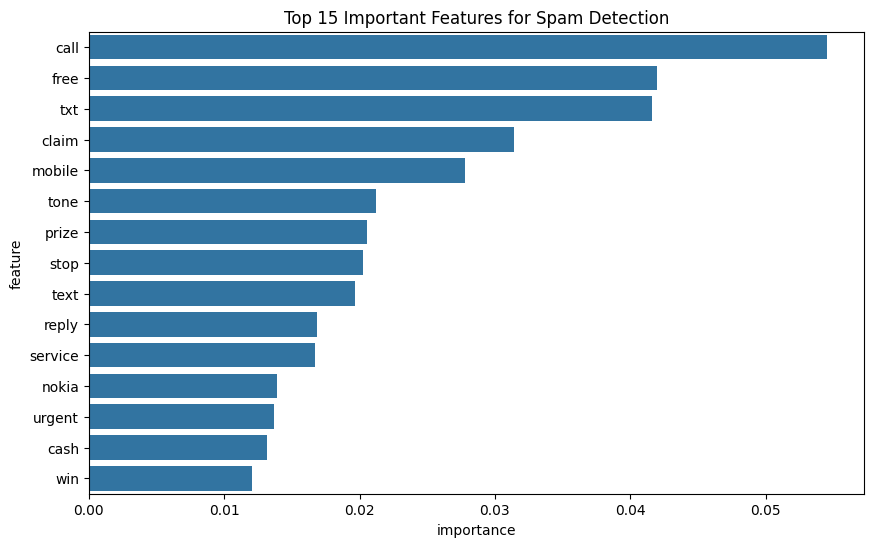

In [ ]:
# Feature Importance Plot
importances = rf_grid.best_estimator_.feature_importances_
top_features = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 15 Important Features for Spam Detection')
plt.savefig('feature_importance.png')  # For report
plt.show()

<Figure size 640x480 with 0 Axes>

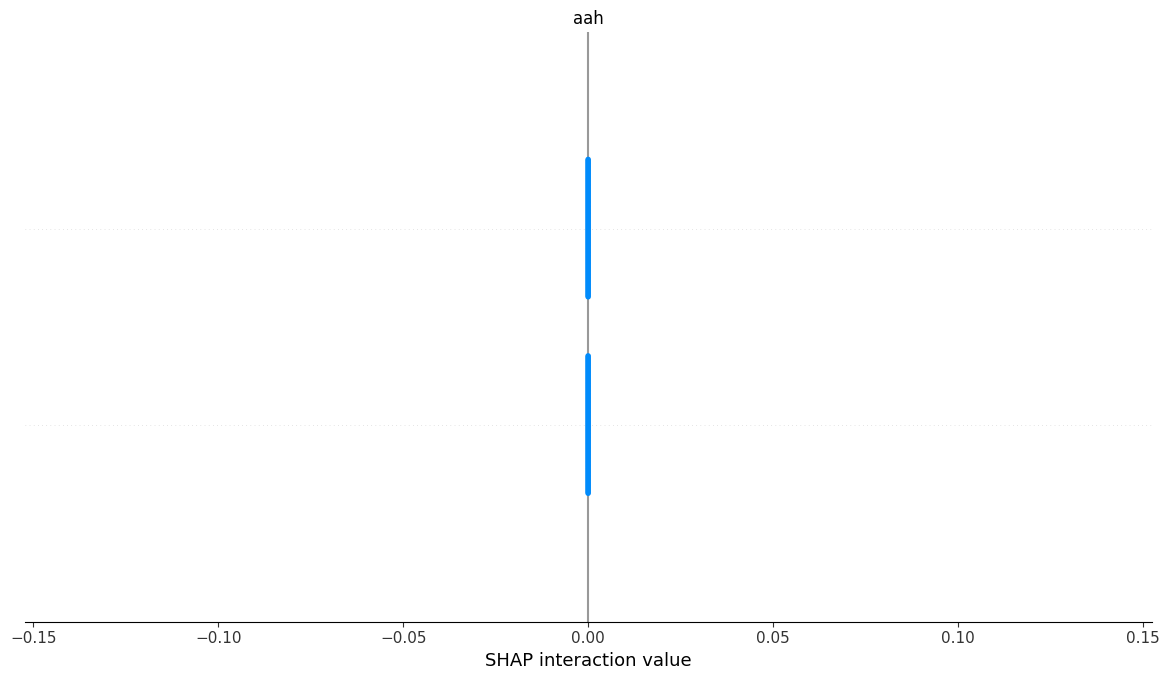

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Fixed SHAP Analysis Cell
try:
    # Convert sparse matrix to dense and ensure float32
    X_test_sample = X_test_tfidf[:100].toarray().astype(np.float32)

    # Initialize explainer
    explainer = shap.TreeExplainer(rf_grid.best_estimator_)

    # Calculate SHAP values (use predict_proba for classification)
    shap_values = explainer.shap_values(X_test_sample)

    # Plot summary
    plt.figure()
    shap.summary_plot(shap_values, X_test_sample,
                     feature_names=tfidf.get_feature_names_out(),
                     class_names=['ham', 'spam'])
    plt.savefig('shap_plot.png', bbox_inches='tight')  # Save for report
    plt.show()

except Exception as e:
    print(f"SHAP Error: {str(e)}")
    print("\nAlternative: Use Permutation Importance")
    from sklearn.inspection import permutation_importance
    result = permutation_importance(rf_grid.best_estimator_,
                                  X_test_tfidf[:100], y_test[:100],
                                  n_repeats=5)
    pd.DataFrame({
        'feature': tfidf.get_feature_names_out(),
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False).head(10)

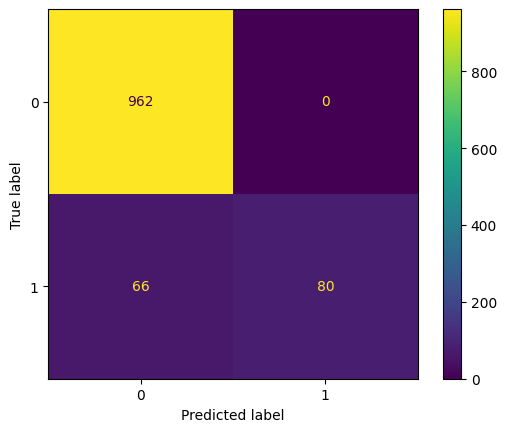

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_grid, X_test_tfidf, y_test)
plt.savefig('confusion_matrix.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

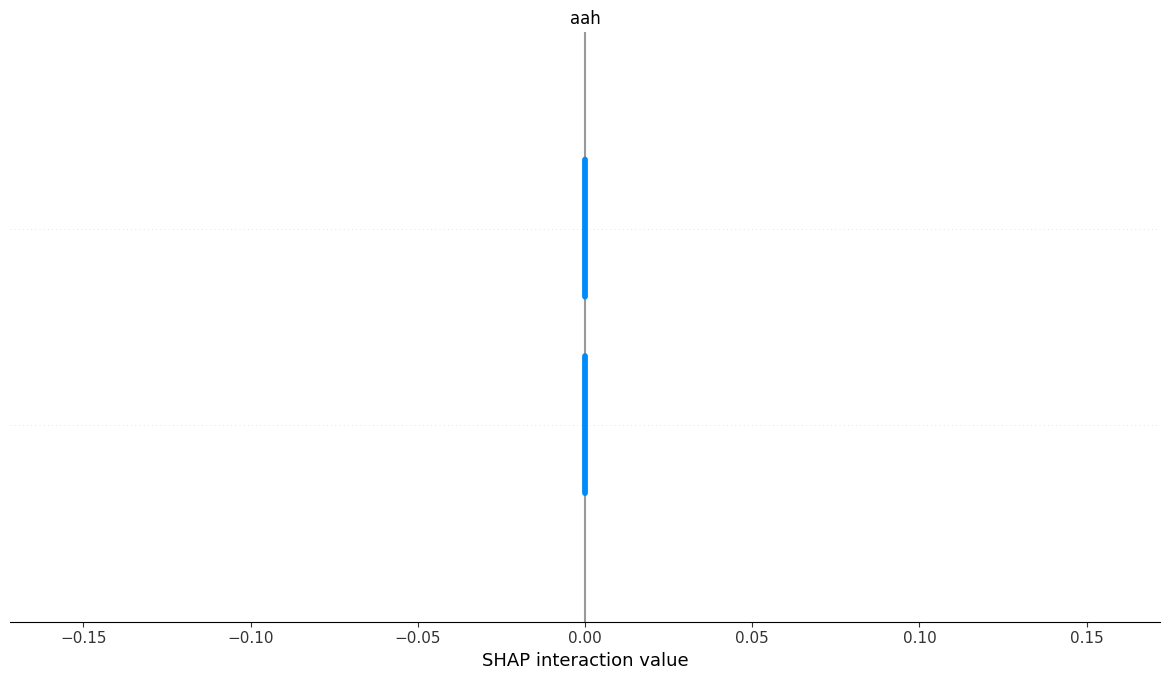

<Figure size 640x480 with 0 Axes>

In [9]:
import shap
explainer = shap.TreeExplainer(rf_grid.best_estimator_)
shap_values = explainer.shap_values(X_test_tfidf[:100].toarray())
shap.summary_plot(shap_values, X_test_tfidf[:100].toarray(),
                 feature_names=tfidf.get_feature_names_out())
plt.savefig('shap_analysis.png', bbox_inches='tight')

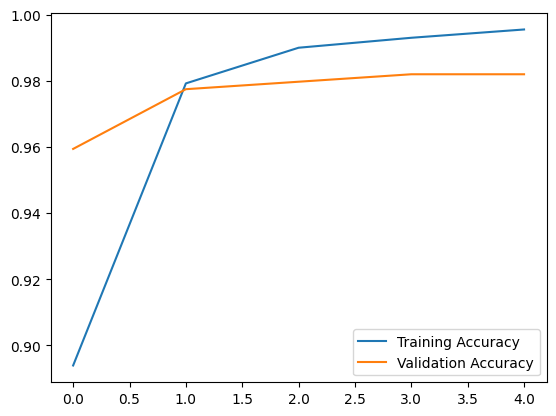

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.savefig('training_curve.png')

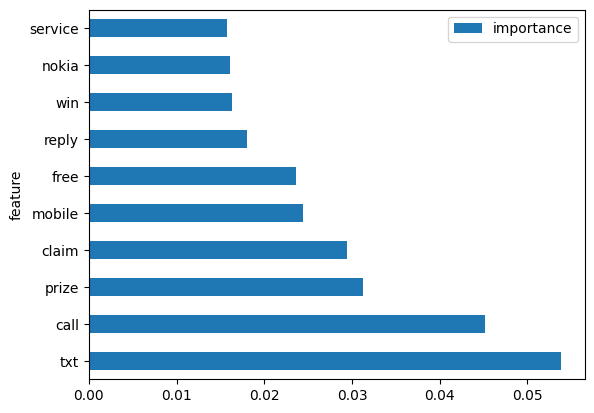

In [11]:
importances = rf_grid.best_estimator_.feature_importances_
top_features = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

top_features.plot.barh(x='feature', y='importance')
plt.savefig('feature_importance.png', bbox_inches='tight')

In [19]:
# Run this in Colab to auto-create your portfolio
!wget https://bit.ly/3xY9ZcT -O setup.py && python setup.py

--2025-04-04 20:00:47--  https://bit.ly/3xY9ZcT
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-04 20:00:47 ERROR 404: Not Found.

